# Bayse Model

In [1]:
import os
os.environ['PYTENSOR_FLAGS'] = 'blas_ldflags='

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
import jax
jax.config.update("jax_platform_name", "cpu")
import jax.numpy as jnp
import pymc as pm
import arviz as az
from graphviz import Digraph

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/pytensor/configparser.py:320: UserWarning: PyTensor does not recognise this flag: blas_ldflags
  warnings.warn(f"PyTensor does not recognise this flag: {key}")


In [2]:
filepath = "../../../data/processed/df_filtered_5years.xlsx"
df = pd.read_excel(filepath)
df['population_change_rate'] = df.groupby('island_id')['population'].pct_change()
df['log_income'] = np.log(df['income'])
df = df.dropna()

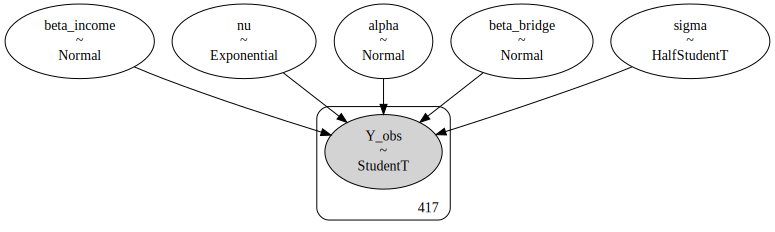

In [3]:
population = df['population_change_rate'].values
bridge = df['dummy_after_bridge_build'].values
log_income = df['log_income'].values

with pm.Model() as model:
    # Priors
    alpha = pm.Normal('alpha', mu=0.0256, sigma=100)
    beta_bridge = pm.Normal('beta_bridge', mu=0.066, sigma=100)
    beta_income = pm.Normal('beta_income', mu=-0.0115, sigma=100)
    sigma = pm.HalfStudentT('sigma', nu=4, sigma=100)
    nu = pm.Exponential('nu', lam=1/30)

    # linear model
    mu = alpha + beta_bridge * bridge + beta_income * log_income

    # Likelihood
    Y_obs = pm.StudentT('Y_obs', mu=mu, sigma=sigma, nu=nu, observed=population)

# モデルの視覚化
graph = pm.model_to_graphviz(model)
graph.render(filename='../../visualization/graphviz/bm_t_5years', format='png', cleanup=True)
graph

In [4]:
with model:
    idata = pm.sample(
        draws=10000,
        tune=1000,
        nuts_sampler="numpyro",
        return_inferencedata=True,
        chains=4,
        target_accept=.95,
    )


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

In [5]:
az.to_netcdf(idata, 't_5years.nc')

't_5years.nc'

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.057,0.056,-0.049,0.160,0.000,0.000,17536.0,19024.0,1.0
beta_bridge,0.068,0.010,0.049,0.087,0.000,0.000,26934.0,24634.0,1.0
beta_income,-0.013,0.003,-0.019,-0.007,0.000,0.000,17561.0,19127.0,1.0
sigma,0.077,0.005,0.068,0.087,0.000,0.000,19255.0,21020.0,1.0
nu,2.894,0.474,2.033,3.763,0.003,0.002,19310.0,22705.0,1.0


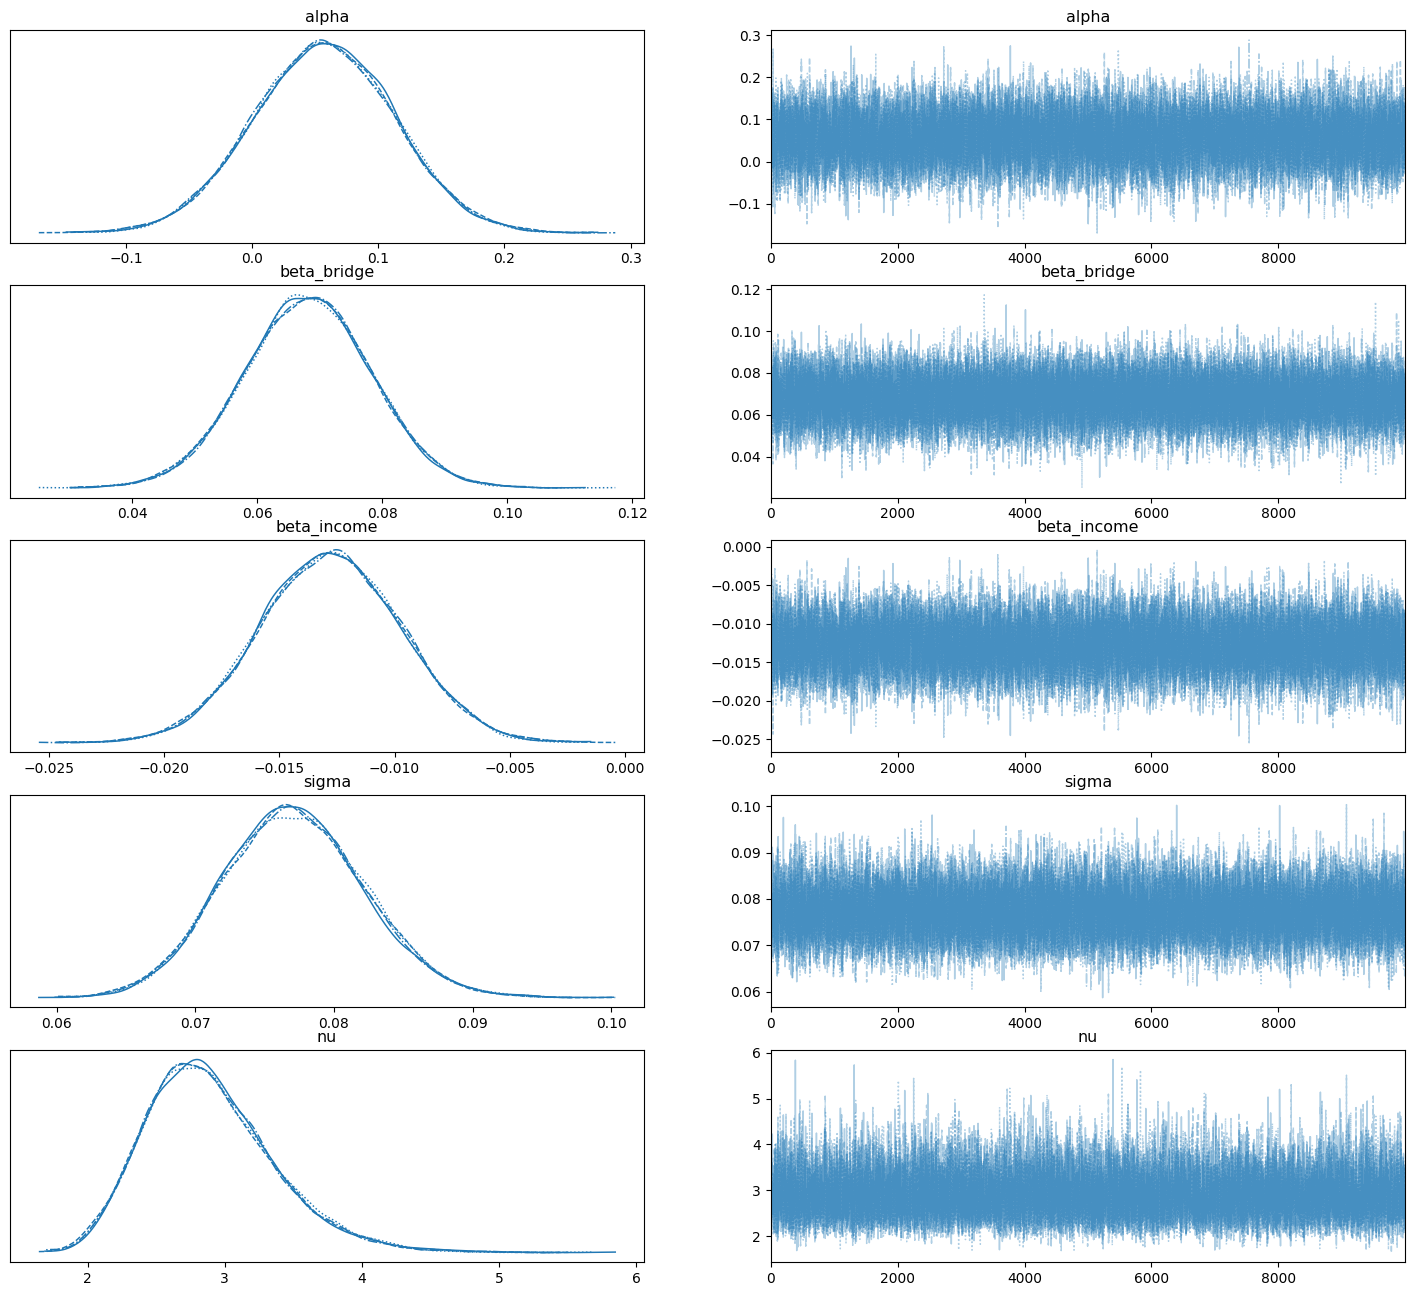

In [6]:
az.plot_trace(idata, figsize=(18, 16))  # サイズを調整
az.summary(idata)

In [7]:
# モデルとトレースが既に得られていると仮定
with model:
    # ポストリア予測サンプルを生成
    ppc = pm.sample_posterior_predictive(idata)

Sampling: [Y_obs]


Output()

In [9]:
idata.extend(ppc)

In [ ]:
# PPCプロットを生成
plt.figure(figsize=(12, 6))
az.plot_ppc(idata, group="posterior")
plt.title("Posterior Predictive Check")
plt.show()


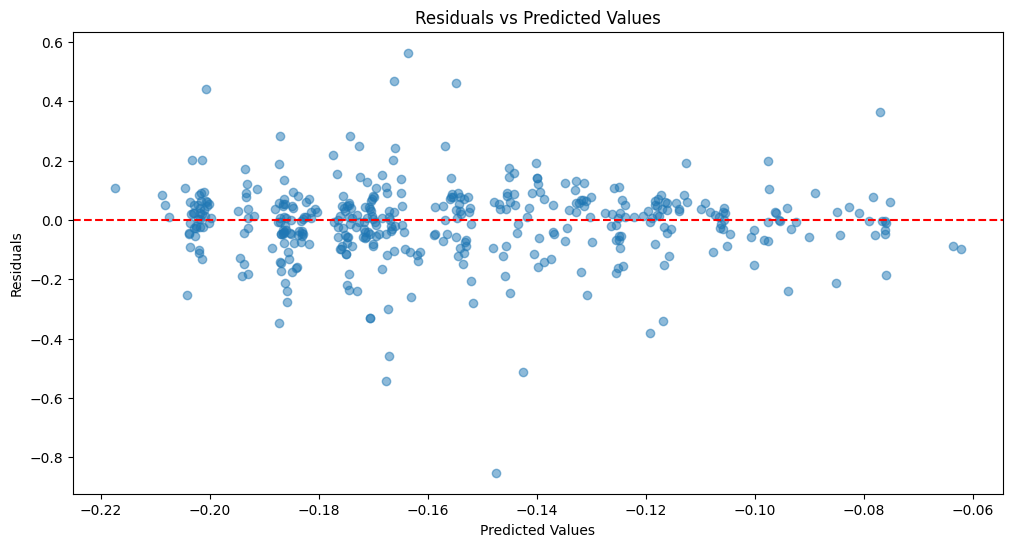

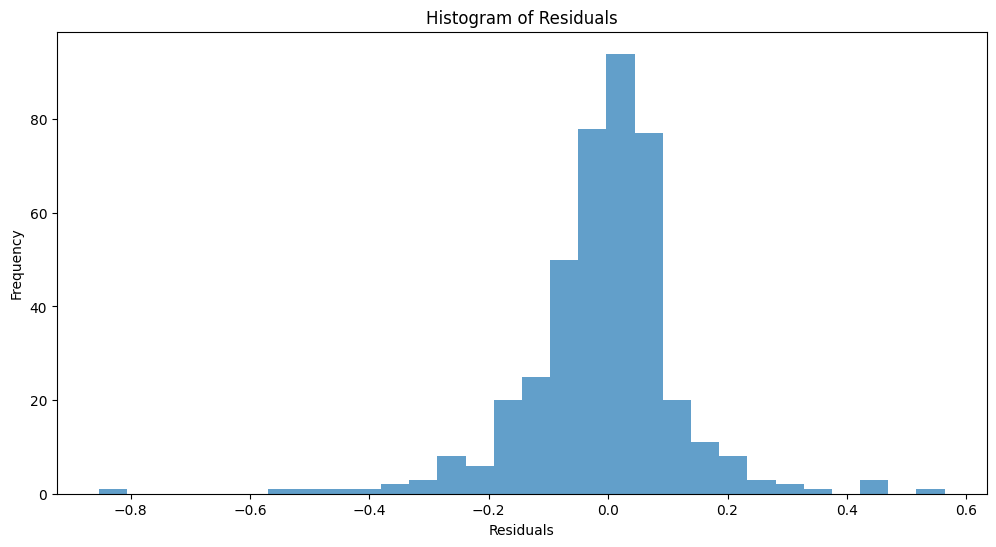

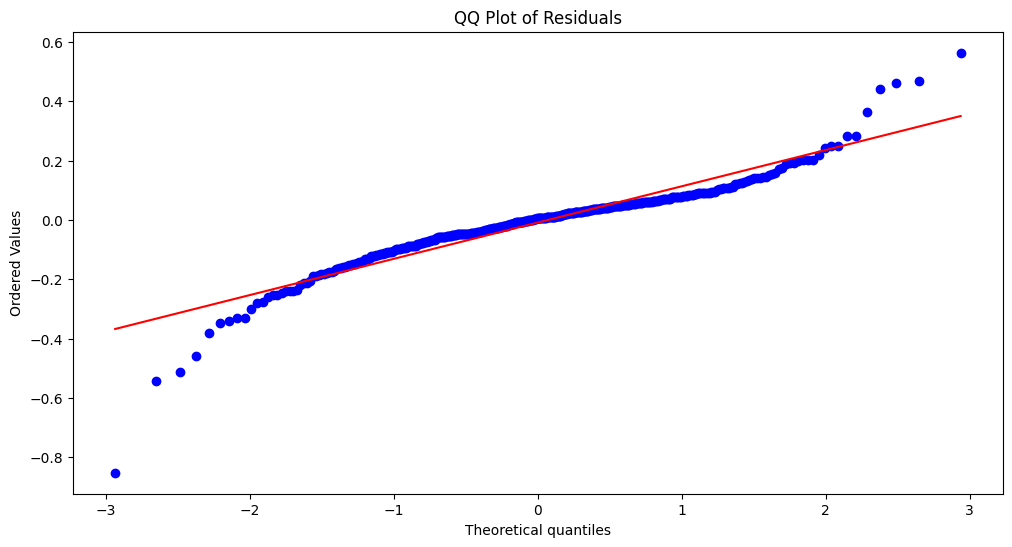

In [10]:
# 予測値の抽出
posterior_predictive = idata.posterior_predictive["Y_obs"].mean(dim=["chain", "draw"]).values

# 観測値の抽出
observed_data = idata.observed_data["Y_obs"].values

# 残差の計算
residuals = observed_data - posterior_predictive

# 残差のプロット
plt.figure(figsize=(12, 6))
plt.scatter(posterior_predictive, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Values")
plt.show()

# 残差のヒストグラム
plt.figure(figsize=(12, 6))
plt.hist(residuals, bins=30, alpha=0.7)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")
plt.show()

# 残差のQQプロット
import scipy.stats as stats
plt.figure(figsize=(12, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("QQ Plot of Residuals")
plt.show()

# 橋ダミーのパラメータが0以上である確率

In [34]:
posterior_samples = idata.posterior

beta_bridge_samples = posterior_samples['beta_bridge']

# 0以上のサンプルの割合を計算
prob_beta_bridge_positive = np.mean(beta_bridge_samples >= 0)

print(f"P(beta_1 >= 0) = {prob_beta_bridge_positive:.4f}")

P(beta_1 >= 0) = 1.0000
